# Competitive pricing using genetic algorithm

In this notebook, we use a genetic algorithm to optimize the pricing strategy of a supermarket store based on the pricing of its competitors. The goal is to determine the optimal prices for a set of products that will maximize the performance of the store while taking into account the pricing strategies of its competitors.

Competitive pricing strategy is important in retail because it helps businesses to remain competitive and attract customers. If a business sets its prices too high, it may lose customers to competitors who offer lower prices. On the other hand, if a business sets its prices too low, it may not be able to cover its costs and may eventually go out of business. Therefore, it is important to find the right balance between pricing and profitability.

A genetic algorithm is a suitable approach for this task because it can search through a large number of possible pricing strategies and find the ones that lead to the highest profit. 

In [1]:
import pandas as pd
import numpy as np
import random
import math

import bisect
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
readRDS = robjects.r['readRDS']

In [2]:
_last_print_len = 0 
def reprint(msg, finish=False): 
    global _last_print_len 
     
    print(' '*_last_print_len, end='\r') 
     
    if finish: 
        end = '\n' 
        _last_print_len = 0 
    else: 
        end = '\r' 
        _last_print_len = len(msg) 
     
    print(msg, end=end)

## Operators

### Random population initialization

We will create the initial set of candidate solutions by randomly generating individuals that represent the prices for each product. The random prices are generated between the minimum and the maximum price that we defined in advance.

In [3]:
def population_generation(population_size,num_products,min_price,max_price,price_step):
    # Define the population of chromosomes
    population = []
    for i in range(population_size):
        chromosome = []
        for j in range(num_products):
            # Generate a random price for each product within the pricing range
            price = round(random.uniform(min_price, max_price) / price_step) * price_step
            chromosome.append(price)
        population.append(chromosome)
    return population

### Fitness evaluation

In this step, we will evaluate the fitness of each chromosome in the population. The fitness function includes three different criteria for evaluating the fitness of a chromosome.

- Price matching: We want the store to match its prices to the competitors for the same products. In this criterion, the fitness of a chromosome is calculated based on the difference between the prices of the products in the chromosome and the prices of the same products in the competitors' stores.
- Psychological pricing: Setting prices below round numbers (such as 4.90 instead of 5) can make the product appear more affordable. In this criterion, we evaluate how well a chromosome implements psychological pricing. The fitness value of a chromosome is calculated based on how close the prices are to round numbers (we check if a price ends in .9 or 9.9). If a price in a chromosome is not close to a round number, a penalty is added to the fitness value based on the distance from the nearest round number. This encourages the chromosomes to use psychological pricing to make their prices more attractive to customers.
- Price beating: To evaluate this criterion, we compare the total cost of a basket of products in the chromosome with the cost of the same basket of products in the competitors' stores. If a chromosome offers a lower cost for the basket, it gets a better fitness value than if it has a higher cost. This encourages the chromosomes to offer competitive prices for a random basket of products to beat their competitors.

In addition to these criteria, we can add more criteria to penalize the fitness when the number of price changes from the last day in our store increases. This encourages the chromosomes to avoid making frequent price changes that can affect menu costs.

In [4]:
# Define the fitness function
def price_matching(chromosome, competitors):
    # Calculate the sum of difference against each competitor
    competitor_differences = []
    for competitor_prices in competitors:
        competitor_difference = 0
        for i in range(len(chromosome)):
            # Calculate the difference between the chromosome price and the competitor price
            price_difference = abs(chromosome[i] - competitor_prices[i])
            # Calculate the total difference of the chromosome price relative to the competitor prices
            competitor_difference += price_difference
        competitor_differences.append(competitor_difference)
    total_differences = sum(competitor_differences)
    return total_differences

def basket_price_beating(chromosome, competitors):
    # Calculate basket expensiveness against each competitor
    competitor_differences = []
    for competitor in competitors:
        competitor_prices = []
        store_prices = []
        # Sample prices from each product category to compose basket
        for category in set(product_categories):
            # Get the indices of the prices that belong to the current category
            indices = [i for i, x in enumerate(product_categories) if x == category]
            # Randomly select one index from the current category
            index = random.choice(indices)
        
            # Append the price at the selected index from chromosome
            competitor_prices.append(competitor[index])
            store_prices.append(chromosome[index])
            
        # Calculate the total price difference of the basket price relative to the competitor prices
        basket_difference = sum(store_prices) - sum(competitor_prices)         
        competitor_differences.append(basket_difference)
    total_differences = sum(competitor_differences)
    return total_differences

def psychological_pricing(chromosome):  
    penalty=0
    for price in chromosome:
        # Checks if the price ends with a 0.9
        if round(price % 1,1) != 0.9:
            closest_9_above = int(price) + 0.9
            closest_9_below = int(price-1) + 0.9
            if abs(price-closest_9_above)>=abs(price-closest_9_below):
                penalty += round(1-abs(price-closest_9_below),1)*10*(math.floor((round(price,1)/0.9))/10)
            elif abs(price-closest_9_above)<abs(price-closest_9_below):
                penalty += round(1-abs(price-closest_9_above),1)*10*(math.floor((round(price,1)/0.9))/10)
        # Checks if the price ends with a 9.9
        if round(price % 10,1) != 9.9:
            closest_9_9_above = math.ceil(price/10)*10 -0.1
            closest_9_9_below = math.floor(price/10)*10 -0.1
            if abs(price-closest_9_9_above)>=abs(price-closest_9_9_below):
                penalty += round(6-abs(price-closest_9_9_below),1)*(math.floor((round(price,1)/9.9))/2)
            elif abs(price-closest_9_9_above)<abs(price-closest_9_9_below):
                penalty += round(6-abs(price-closest_9_9_above),1)*(math.floor((round(price,1)/9.9))/2)
    return penalty/2


def fitness_function(population, competitors):
    # Compute the fitness of each chromosome in the population
    fitness_values = []
    for chromosome in population:
        fitness_value = price_matching(chromosome, competitors)
        fitness_value += basket_price_beating(chromosome, competitors)
        fitness_value += psychological_pricing(chromosome)
        fitness_values.append(fitness_value)
    return fitness_values

### Parents selection

We choose individuals (parents) from the population to be used for creating new offspring through crossover and mutation. There are various selection strategies that can be used, such as tournament selection, roulette wheel selection, rank-based selection, and random selection, each with their own strengths and weaknesses and have a significant impact on the performance of the genetic algorithm.

##### Tournament Selection
We randomly select a subset of chromosomes from the population and find the two fittest chromosomes in the subset based on their fitness values. The fittest chromosome is selected as the first parent, and the second fittest chromosome is selected as the second parent.

##### Roulette Wheel Selection
We calculate the total fitness of the population and the cumulative probabilities for each chromosome in the population. Then, we select two parents using the roulette wheel method based on the cumulative probabilities (it's similar to PPS sampling).

##### Rank Selection
We rank the chromosomes by their fitness values and calculate the selection probabilities based on the ranks. Then, we select two chromosomes using the rank probabilities.

##### Random Selection
We select two chromosomes at random from the population.

In [5]:
def parents_selection(population, fitness_values, tournament_size, selection_strategy):
    # Create an empty list to store the selected chromosomes
    selected_chromosomes = []

    if selection_strategy == 'tournament':
        # Randomly select a subset of chromosomes from the population
        tournament_indices = random.sample(range(len(population)), tournament_size)
        tournament_chromosomes = [population[i] for i in tournament_indices]
        # Find the fittest chromosome in the subset
        tournament_fitness_values = [fitness_values[i] for i in tournament_indices]
        #fittest_index = tournament_fitness_values.index(max(tournament_fitness_values))
        fittest_index = tournament_fitness_values.index(min(tournament_fitness_values))
        fittest_chromosome = tournament_chromosomes[fittest_index]
        # Remove the fittest chromosome from the list
        tournament_chromosomes.remove(fittest_chromosome)
        # Find the second fittest chromosome in the subset
        tournament_fitness_values.remove(max(tournament_fitness_values))
        second_fittest_index = tournament_fitness_values.index(max(tournament_fitness_values))
        second_fittest_chromosome = tournament_chromosomes[second_fittest_index]
        selected_chromosomes.extend([fittest_chromosome, second_fittest_chromosome])
    elif selection_strategy == 'roulette':
        # Calculate the total fitness of the population
        total_fitness = sum(fitness_values)
        # Invert fitness values to calculate probabilities inversely proportional to fitness
        inverted_fitness_values = [total_fitness - fitness_value + 1 for fitness_value in fitness_values]
        # Calculate the cumulative probabilities for each chromosome in the population
        #cumulative_probabilities = [sum(fitness_values[:i+1])/total_fitness for i in range(len(population))]
        cumulative_probabilities = [sum(inverted_fitness_values[:i+1])/sum(inverted_fitness_values) for i in range(len(population))]        
        # Select the first parent using roulette wheel selection
        parent1_index = bisect.bisect_left(cumulative_probabilities, random.uniform(0, 1))
        parent1 = population[parent1_index]
        # Select the second parent using roulette wheel selection
        parent2_index = bisect.bisect_left(cumulative_probabilities, random.uniform(0, 1))
        parent2 = population[parent2_index]
        # Add the selected parents to the selected chromosomes list
        selected_chromosomes.extend([parent1, parent2])
    elif selection_strategy == 'rank':
        # Rank the chromosomes by their fitness values
        ranked_indices = sorted(range(len(fitness_values)), key=lambda i: fitness_values[i])
        ranked_chromosomes = [population[i] for i in ranked_indices]
        # Calculate the selection probabilities based on the ranks
        #rank_probabilities = [i / sum(range(1, len(ranked_chromosomes) + 1)) for i in range(1, len(ranked_chromosomes) + 1)]
        rank_probabilities = [(len(ranked_chromosomes)-i+1) / sum(range(1, len(ranked_chromosomes) + 1)) for i in range(1, len(ranked_chromosomes) + 1)]
        # Select two chromosomes using the rank probabilities
        selected_chromosomes = random.choices(ranked_chromosomes, weights=rank_probabilities, k=2)
    elif selection_strategy == 'random':
        # Select two chromosomes at random
        selected_chromosomes = random.choices(population, k=2)

    return selected_chromosomes

### Crossover

We use crossover to generate diversity in the population and to potentially combine better prices from different parent chromosomes to create better solutions. The offspring inherit genetic information from both parents through the process of crossover, which occurs at one or more points along the chromosomes. The goal is to generate diverse price combination that have the potential to be fitter than their parents, and thereby improve the overall fitness of the population over time.


##### Single point crossover
A random point is selected in the parent chromosomes and the genetic information before the point is taken from one parent and after the point from the other parent to create two offspring chromosomes.

##### Two point crossover
Two random points are selected in the parent chromosomes and the genetic information between the two points is exchanged to create two offspring chromosomes.

##### Uniform crossover
The offspring chromosomes are created by randomly selecting genetic information from both parent chromosomes with equal probability. Each gene in the offspring is selected from either parent with 50% probability.

In [6]:
def crossover(parent1, parent2, crossover_strategy):
    
    # Perform the appropriate crossover strategy
    if crossover_strategy == 'single_point':
        # Select a random crossover point
        crossover_point = random.randint(1, len(parent1) - 1)
        offspring1 = parent1[:crossover_point] + parent2[crossover_point:]
        offspring2 = parent2[:crossover_point] + parent1[crossover_point:]
    elif crossover_strategy == 'two_point':
        # Select two random crossover points
        crossover_point1 = random.randint(1, len(parent1) - 2)
        crossover_point2 = random.randint(crossover_point1 + 1, len(parent1) - 1)
        offspring1 = parent1[:crossover_point1] + parent2[crossover_point1:crossover_point2] + parent1[crossover_point2:]
        offspring2 = parent2[:crossover_point1] + parent1[crossover_point1:crossover_point2] + parent2[crossover_point2:]
    elif crossover_strategy == 'uniform':
        # Select genes from both parents with equal probability
        offspring1 = [parent1[i] if random.random() < 0.5 else parent2[i] for i in range(len(parent1))]
        offspring2 = [parent2[i] if random.random() < 0.5 else parent1[i] for i in range(len(parent2))]
    
    return offspring1, offspring2

### Mutation

We use mutation to introduce random changes in an individual's genome (pricing). It is used to maintain genetic diversity in the population and to prevent the algorithm from getting stuck in local optima. The mutation operator randomly changes one or more genes in an individual's chromosome with a certain probability we define in the mutation rate.

##### Random resetting
In this strategy, a random gene in the chromosome is replaced with a new random value within the specified range.

##### Swap
In this strategy, two random genes in the chromosome are swapped.

##### Scramble
In this strategy, a subset of genes within the chromosome are scrambled randomly.

##### Inversion
In this strategy, a subset of genes within the chromosome are inverted (i.e., their order is reversed).

In [7]:
def mutation(offspring, mutation_rate, min_price, max_price, mutation_strategy):
    for i in range(len(offspring)):
        # Generate a random number between 0 and 1
        r = random.random()
        # If the random number is less than the mutation rate, mutate the gene
        if r < mutation_rate:
            if mutation_strategy == 'random_resetting':
                # Replace the gene with a new random value
                offspring[i] = round(random.uniform(min_price, max_price) / price_step) * price_step
            elif mutation_strategy == 'swap':
                # Swap the current gene with another random gene in the chromosome
                j = i
                while j == i:
                    j = random.randint(0, len(offspring) - 1)
                offspring[i], offspring[j] = offspring[j], offspring[i]
            elif mutation_strategy == 'scramble':
                # Scramble a subset of genes within the chromosome
                j = random.randint(0, len(offspring) - 1)
                k = random.randint(j, len(offspring) - 1)
                subset = offspring[j:k]
                random.shuffle(subset)
                offspring[j:k] = subset
            elif mutation_strategy == 'inversion':
                # Invert a subset of genes within the chromosome
                j = random.randint(0, len(offspring) - 1)
                k = random.randint(j, len(offspring) - 1)
                subset = offspring[j:k]
                subset.reverse()
                offspring[j:k] = subset
                
    return offspring

In [8]:
def join_population(population, offspring1, offspring2):
    population.append(offspring1)
    population.append(offspring2)
    return population

### Migration

We use migration to exchange individuals between different subpopulations (islands) in order to increase genetic diversity and prevent premature convergence to suboptimal solutions.

##### Elite migration
In this policy, the fittest individuals from the source island are exchanged with the least fit individuals from the destination island.

##### Random migration
In this policy, random individuals are selected from both the source and destination islands to be exchanged.

In [9]:
def elite_migration(islands, fitness_values, source_index, dest_index,num_migrants):
    # Find the indices of the fittest individuals in the source island and the least fit individuals in the destination island
    source_indices = sorted(range(len(fitness_values[source_index])), key=lambda j: fitness_values[source_index][j], reverse=False)[:num_migrants]
    dest_indices = sorted(range(len(fitness_values[dest_index])), key=lambda j: fitness_values[dest_index][j], reverse=True)[:num_migrants]
    # Exchange the least fit individuals in the destination island with the fittest individuals from the source island
    for s, d in zip(source_indices, dest_indices):
        emigrants1 = islands[source_index][s].copy()
        emigrants2 = islands[dest_index][d].copy()
        islands[dest_index][d] = emigrants1
        islands[source_index][s] = emigrants2
        fitness_values[dest_index][d] = fitness_function([islands[source_index][s]], competitors)[0]
        fitness_values[source_index][s] = fitness_function([islands[dest_index][d]], competitors)[0]

def random_migration(islands, fitness_values, source_index, dest_index, num_migrants):
    # Choose random individuals from the source island and destination island to exchange
    source_indices = random.sample(range(len(islands[source_index])), num_migrants)
    dest_indices = random.sample(range(len(islands[dest_index])), num_migrants)
    # Exchange the chosen individuals
    for s, d in zip(source_indices, dest_indices):
        emigrants1 = islands[source_index][s].copy()
        emigrants2 = islands[dest_index][d].copy()
        islands[dest_index][d] = emigrants1
        islands[source_index][s] = emigrants2
        fitness_values[dest_index][d] = fitness_function([islands[source_index][s]], competitors)[0]
        fitness_values[source_index][s] = fitness_function([islands[dest_index][d]], competitors)[0]        

def migration(islands, fitness_values, immigration_rate, immigration_policy):
    # Determine the number of immigrants to send and the number to receive
    num_migrants = int(immigration_rate * len(islands[0]))
    for i in range(len(islands)):
        # Determine the index of the island to exchange immigrants with
        exchange_index = (i + 1) % len(islands)
        # Perform immigration based on the specified policy
        if immigration_policy == 'elite_migration':
            elite_migration(islands, fitness_values, i, exchange_index,num_migrants)
        elif immigration_policy == 'random_migration':
            random_migration(islands,fitness_values, i, exchange_index,num_migrants)
    
    return islands, fitness_values

#### Data

In [10]:
# Product categories to optimize
categories = ["rice","pasta","legumes and cereals","cheese","yogurt","biscuits","waffles","chocolates","ketchup, mayonnaise and mustard"]

# Desired date
date= '2019-07-15'

# List of stores
stores = ['1049', '1342']

# Import the data
store_data = [pd.DataFrame() for i in range(len(stores))]

for category in categories:
    for i, store in enumerate(stores):
        # Read the data for the current store and category
        category_store_data = readRDS('G:/retail data/' + category + '/' + store + '.rds')
        category_store_data = pandas2ri.rpy2py_dataframe(category_store_data)
        category_store_data['product_category'] = category
        category_store_data['Date'] = pd.to_datetime(category_store_data['Date'], utc=True, unit='d').apply(lambda x: x.strftime('%Y-%m-%d'))
        category_store_date_data = category_store_data[category_store_data['Date'] == date]
        store_data[i] = pd.concat([store_data[i], category_store_date_data], axis=0)
    
# Remove the products that are not common in all stores
for i in range(len(stores)):
    for j in range(i+1, len(stores)):
        store_data[i] = store_data[i][store_data[i]['ProductDescription'].isin(store_data[j]['ProductDescription'])]
        store_data[j] = store_data[j][store_data[j]['ProductDescription'].isin(store_data[i]['ProductDescription'])]
    
# Sort the data by product description
for i in range(len(stores)):
    store_data[i].sort_values(by=['ProductDescription'], inplace=True)

# Define the number of products
num_products = len(list(store_data[0]['FinalPrice']))
print('Number of products:', num_products)
product_categories = list(store_data[0]['product_category'])

# Define the competitors
competitors = [list(store['FinalPrice']) for store in store_data]

# Define the pricing range
min_price = min([min(list(store['FinalPrice'])) for store in store_data])
max_price = max([max(list(store['FinalPrice'])) for store in store_data])

Number of products: 266


#### Parameters

In [11]:
# Define the population size
population_size = 10
# Define the tournament size for parent selection
tournament_size=2
# Define the price step - by the Israeli law prices can be defined in steps of 10 cents
price_step = 0.1
#Define the mutation rate
mutation_rate = 0.5
# Define the number of generations
gen_num = 1000
#Define the immigration rate
immigration_rate = 0.2
# Define the number of periods until the next immigration
immigration_periods = 200

# Define the strategies
selection_strategies = ['tournament','roulette','rank','random']
crossover_strategies = ['single_point','two_point','uniform']
mutation_strategies = ['random_resetting','swap','scramble','inversion']
immigration_policies = ['elite_migration','random_migration']

In [12]:
# Create a list of all possible combinations of selection, crossover, and mutation strategies -each will be an island
strategy_combinations = list(itertools.product(selection_strategies, crossover_strategies, mutation_strategies))
len(strategy_combinations)

48

#### Algorithm

In our genetic algorithm application, we start with an initial population of chromosomes representing potential solutions to our problem. In each generation, we use the fitness function to evaluate the fitness of each chromosome in the population. To generate new individuals, we are using here two methods: through crossover and mutation of parent chromosomes, and through cloning and mutation of existing individuals.

- **Offspring generation**: In this method, the algorithm creates new individuals by using crossover and mutation operations on the parent chromosomes. This generates new individuals that combine prices from their parents while introducing some random variation, allowing the population to explore a wider range of potential solutions.
- **Cloning**: This is an extension to the genetic algorithm where we create new individuals by making clones, of existing individuals in the population and applying mutation to them. This creates new individuals that may be slightly different from their parent, and helps to prevent premature convergence to a suboptimal solution. By creating clones and adding mutation, we can explore nearby regions of the search space and potentially find better solutions.

We use both offspring generation and cloning because it can improve the performance of the genetic algorithm by exploring different regions of the search space.

In addition, the algorithm implements an immigration policy where, every $n$ generations, a subset of the population is exchanged between different islands, to increase genetic diversity and explore new regions of the search space.

In [13]:
# Create a list of islands, one for each strategy combination
islands = []
fitness_values = []
best_scores = []

for strategy_combination in strategy_combinations:
    # Generate population for the current strategy combination
    population = population_generation(population_size, num_products, min_price, max_price, price_step)
    islands.append(population)
    
    # Evaluate fitness values for the current population
    fitness_value = fitness_function(population, competitors)
    fitness_values.append(fitness_value)
    
    # Store the best score for the current generation for the current population
    best_score = min(fitness_value)
    best_scores.append([best_score])
    
overall_best_score = min([min(scores) for scores in best_scores])
global_score = " Global score:" + str(overall_best_score) + " in generation: 0"
print(global_score)

 Global score:8595.84 in generation: 0


In [14]:
for gen in range(gen_num):
    for i in range(len(islands)):
        population = islands[i]
        selection_strategy, crossover_strategy, mutation_strategy = strategy_combinations[i]
        
        # Offsprings creartion
        # Selection, crossover, mutation
        parents = parents_selection(population, fitness_values[i], tournament_size, selection_strategy)
        offspring1, offspring2 = crossover(parents[0], parents[1], crossover_strategy)
        offspring1 = mutation(offspring1, mutation_rate, min_price, max_price, mutation_strategy)
        offspring2 = mutation(offspring2, mutation_rate, min_price, max_price, mutation_strategy)
        
        # clones creartion
        # Selection, mutation
        clones = parents_selection(population, fitness_values[i], tournament_size, selection_strategy)
        clone1, clone2 = clones[0], clones[1]
        clone1 = mutation(clone1, mutation_rate, min_price, max_price, mutation_strategy)
        clone2 = mutation(clone2, mutation_rate, min_price, max_price, mutation_strategy)
        
        # Join to the offsprings and clones to the population and evaluate the fitness
        population = join_population(population, offspring1, offspring2)
        population = join_population(population, clone1, clone2)
        fitness_values[i] = fitness_function(population, competitors)        
        # select the four least fit chromosomes
        lowest_indices = sorted(range(len(fitness_values[i])), key=lambda j: fitness_values[i][j], reverse=True)[:2]
        # Remove the chromosomes with the lowest fitness values from the population
        population = [population[j] for j in range(len(population)) if j not in lowest_indices]
        fitness_values[i] = [fitness_values[i][j] for j in range(len(fitness_values[i])) if j not in lowest_indices]
        
        # Update the population in the island
        islands[i] = population
        
        # Print the overall best score if it is the best score so far
        overall_best_score = min([min(scores) for scores in best_scores])
        if min(fitness_values[i]) < overall_best_score:
            new_global_score = "New global score:" + str(min(fitness_values[i])) + " in island: "+ str(i+1) + " in generation: "+str(gen+1)
            reprint(new_global_score)
            overall_best_score = min(fitness_values[i])
            global_score = " Global score:" + str(min(fitness_values[i])) + " in island: "+ str(i+1) + " in generation: "+str(gen+1)
        # Print the best score for this island if it is the best score so far
        if min(fitness_values[i]) < min(best_scores[i]):
            new_score = "New best score:" + str(min(fitness_values[i])) + " in island: "+ str(i+1) + " in generation: "+str(gen+1)
            reprint(new_score + global_score)

            
        # Store the best score for this generation
        best_scores[i].append(min(fitness_values[i]))
        
        # Perform immigration every n generations
        if gen % immigration_periods == 0:
            chosen_policy = random.choice(immigration_policies)
            islands, fitness_values = migration(islands, fitness_values, immigration_rate, chosen_policy)

### Evaluation

##### Present the best solution

In [28]:
best_chromosome = None
best_score = float('inf')

# Loop over each island
for i in range(len(islands)):
    # Find the index of the best fitness score in this island
    best_index = fitness_values[i].index(min(fitness_values[i]))
    # If the best score in this island is better than the current overall best score, update the best chromosome and best score
    if fitness_values[i][best_index] < best_score:
        best_chromosome = islands[i][best_index]
        best_score = fitness_values[i][best_index]
        best_strategy = strategy_combinations[i]

print("Best score:", best_score)
print("Best strategy: parent selection:", best_strategy[0], 'crossover:',best_strategy[1], 'mutation:',best_strategy[2])
best_chromosome_df = pd.DataFrame({'Product':list(store_data[0]['ProductDescription']),'Recommended price': best_chromosome, 'Category': product_categories})
best_chromosome_df[:5]

Best score: 2901.6650000000022
Best strategy: parent selection: rank crossover: uniform mutation: inversion


,Product,Recommended price,Category
0,אורז בסמטי מהדרין דאוואט 1 קילו,8.9,rice
1,אורז פרסי קלאסי סוגת 1 קילו,6.9,rice
2,אצבעות וופל מצופות שוקולד חלב במילוי קרם בטעם ...,6.6,waffles
3,אצבעות וופל מצופות שוקולד מריר במילוי קרם טראפ...,6.6,waffles
4,"באדי יוגורט בטעם תות שדה 3% מהדרין תנובה 500 מ""ל",9.9,yogurt


##### Psychological prices distribution

We will visulaise the distribution of price endigs to evaluate our best solution. The first histogram shows the frequency of decimal values in the prices ending in the best solution, while the second histogram shows the frequency of unit digits for prices ending in .9.

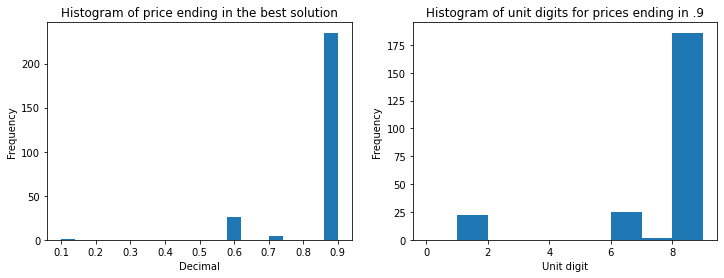

In [16]:
# Calculate the decimal frequency of the chromosome
decimal_frequencies = []
decimal_frequencies = [x % 1 for x in best_chromosome]

# Extract decimal values that end in .9
ending_in_9 = [x for x in best_chromosome if str(x)[-2:] == '.9']
# Extract unit digits
unit_digits = [int(str(x)[-3]) for x in ending_in_9]

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(decimal_frequencies, bins=20)
axs[0].set_xlabel('Decimal')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of price ending in the best solution')

axs[1].hist(unit_digits, bins=range(10))
axs[1].set_title("Histogram of unit digits for prices ending in .9")
axs[1].set_xlabel("Unit digit")
axs[1].set_ylabel("Frequency")

plt.show()

We can observe a strong tendency to price products with endings of ".9" and a lesser extent tendency to price products with endings of "9.9", which can create a psychological impact on the buyers.

##### Price matching

We will visualize the matched priced for each competitor and each product category 

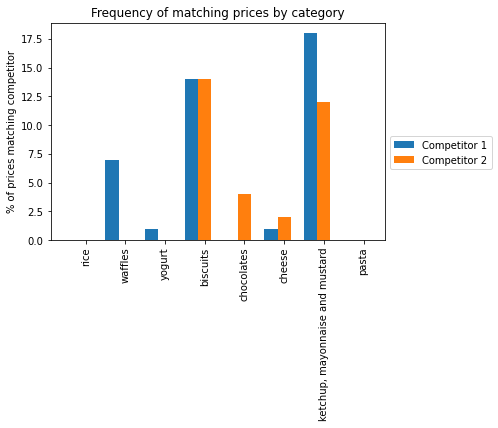

In [25]:
# Create a list of dictionaries to store the frequencies of matching prices by category for each competitor
match_freq_list = [{category: 0 for category in product_categories} for _ in range(len(competitors))]

# Compare to the competitors' prices
for i, price in enumerate(best_chromosome):
    category = product_categories[i]
    for j, competitor in enumerate(competitors):
        if price == competitor[i]:
            match_freq_list[j][category] += 1

# Calculate the total number of prices in each category
category_totals = {category: product_categories.count(category) for category in product_categories}
# Calculate the frequency of matching prices as a percentage for each competitor
match_percent_list = [{category: round((match_freq_list[j][category] / category_totals[category]) * 100) for category in product_categories} for j in range(len(competitors))]

# Plot
fig, ax = plt.subplots()
categories = list(match_percent_list[0].keys())
num_competitors = len(competitors)
bar_width = 1/(num_competitors+1)

for j in range(num_competitors):
    values = list(match_percent_list[j].values())
    ax.bar([i+(j-num_competitors/2)*bar_width for i in range(len(categories))], values, width=bar_width, label=f"Competitor {j+1}")
    
ax.set_ylabel('% of prices matching competitor')
ax.set_title('Frequency of matching prices by category')
ax.set_xticks([i for i in range(len(categories))])
ax.set_xticklabels(categories, rotation=90)
ax.legend(bbox_to_anchor=(1, 0.5))
plt.show()

We can see that in some categories, we matched our prices in higher percents than other categories.

Now, we will visualise how much prices of our best solution differ from the competitors' prices

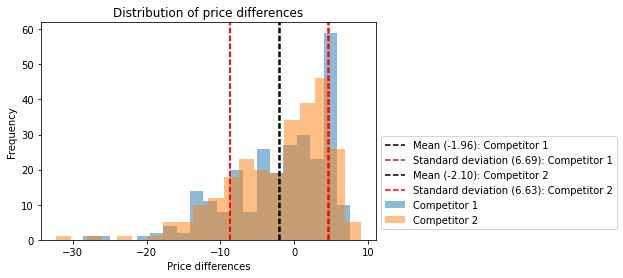

In [18]:
price_diffs = []
# Calculate the price differences
for competitor in competitors:
    diffs = []
    for i, price in enumerate(best_chromosome):
        diff = price - competitor[i]
        diffs.append(diff)
    price_diffs.append(diffs)

# Plot the distribution of price differences for each competitor
fig, ax = plt.subplots()
for i, competitor in enumerate(competitors):
    mu, sigma = np.mean(price_diffs[i]), np.std(price_diffs[i])
    ax.hist(price_diffs[i], bins=20, alpha=0.5, label='Competitor {}'.format(i+1))
    ax.axvline(mu, color='k', linestyle='--', label='Mean ({:.2f}): Competitor {}'.format(mu, i+1))
    ax.axvline(mu-sigma, color='r', linestyle='--', label='Standard deviation ({:.2f}): Competitor {}'.format(sigma, i+1))
    ax.axvline(mu+sigma, color='r', linestyle='--')
ax.set_xlabel('Price differences')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of price differences')
ax.legend(bbox_to_anchor=(1, 0.5))
plt.show()

From the plot, we can see that the mean price differences for all competitors are negative, which indicates that the prices in the best solution are lower than those of the competitors. We can also see that the distribution of price differences for each competitor is left skewed.

##### Basket price beating

We will evaluate how much we can attract the costumers by giving cheaper price for a random basket of products. We will do it by using bootstrap to create distribution of the difference between our best solution to the competitors' basket prices.

Difference mean: -1.425740624999999


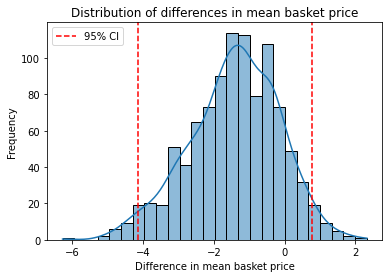

In [24]:
# Set the number of samples to generate
num_samples = 1000

bootstrap_means = []
bootstrap_differences = []

for i in range(num_samples):
    competitor_samples = []
    store_samples = []
    for competitor in competitors:
        competitor_prices = []
        for category in set(product_categories):
            # Get the indices of the prices that belong to the current category
            indices = [i for i, x in enumerate(product_categories) if x == category]
            # Randomly select one index from the current category
            index = random.choice(indices)
        
            # Append the price at the selected index from chromosome
            competitor_prices.append(competitor[index])
            store_samples.append(best_chromosome[index])
        competitor_samples.append(np.mean(competitor_prices))
    
    # Calculate the sample means of the competitor prices and store prices
    competitor_sample_mean = np.mean(competitor_samples)
    store_sample_mean = np.mean(store_samples)
    bootstrap_means.append((competitor_sample_mean, store_sample_mean))
    
    # Calculate the differences between the sample means
    difference = store_sample_mean - competitor_sample_mean
    bootstrap_differences.append(difference)

print('Difference mean:',np.mean(bootstrap_differences))
# Calculate the 95% confidence interval
lower = np.percentile(bootstrap_differences, 2.5)
upper = np.percentile(bootstrap_differences, 97.5)

# Plot the distribution of the differences between the sample means
fig, ax = plt.subplots()
sns.histplot(bootstrap_differences, kde=True, ax=ax)
ax.axvline(lower, color='r', linestyle='--', label='95% CI')
ax.axvline(upper, color='r', linestyle='--')
ax.set_xlabel('Difference in mean basket price')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of differences in mean basket price')
ax.legend()
plt.show()

The plot indicates that the mean difference is below zero, suggesting that a random basket price in our best solution is cheaper than its competitors, by ~ 1.4 NIS. This indicates that the store's prices are competitive with its competitors.

##### Improvement in best scores over generations

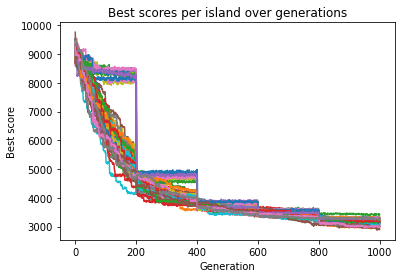

In [20]:
# Loop over each island and plot its best scores
for i in range(len(best_scores)):
    plt.plot(best_scores[i], label=f'Island {i+1}')
plt.title('Best scores per island over generations')
plt.xlabel('Generation')
plt.ylabel('Best score')
plt.show()

The plot shows the best scores obtained by each island over the generations in the genetic algorithm. From the plot, we can also conclude that the immigration operator has a significant impact on the improvement of the best score for some islands. This indicates that the exchange of genetic material between different islands has played a critical role in improving the quality of the solutions found by the algorithm.